In [1]:
import math
from collections import defaultdict
from dataclasses import dataclass
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


In [6]:
@dataclass
class TrainingConfig:
    sparsity_coeff: float = 0.1  # Reduced from 1.0
    binary_coeff: float = 0.1  # Reduced from 1.0
    temp_start: float = 2.0  # Start with higher temperature
    temp_end: float = 0.01  # End with lower temperature
    epochs: int = 100
    num_examples: int = 1000
    batch_size: int = 32
    learning_rate: float = 0.001  # Reduced from 0.01
    num_classes: int = 4
    device: str = "mps"


class CosineScheduler:
    def __init__(self, start_value: float, end_value: float, num_steps: int):
        self.start = start_value
        self.end = end_value
        self.num_steps = num_steps
        self.current_step = 0
        self.value = start_value

    def step(self) -> float:
        value = self.end + 0.5 * (self.start - self.end) * (
            1 + math.cos((self.current_step / self.num_steps) * math.pi)
        )
        self.current_step = min(self.current_step + 1, self.num_steps)
        self.value = value
        return value


class MetricsTracker:
    def __init__(self):
        self.metrics = defaultdict(list)

    def update_epoch_metrics(self, epoch_metrics: Dict[str, float]):
        for key, value in epoch_metrics.items():
            self.metrics[key].append(value)

    def plot_metrics(self):
        num_metrics = len(self.metrics)
        fig, axes = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 4))

        for ax, (metric_name, values) in zip(axes, self.metrics.items()):
            ax.plot(values)
            ax.set_title(metric_name.replace("_", " ").title())
            ax.grid(True)

        plt.tight_layout()
        plt.show()


class Trainer:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.metrics = MetricsTracker()
        self.temp_scheduler = CosineScheduler(
            config.temp_start,
            config.temp_end,
            config.num_examples // config.batch_size * config.epochs,
        )

    def create_dataset(self):
        # Generate random points in the feature space
        data = torch.randn(self.config.num_examples, 16) * 2.0

        # Centers much closer together in a smaller square
        centers = torch.tensor(
            [
                [0.7, 0.7],  # Class 0 center
                [-0.7, 0.7],  # Class 1 center
                [-0.7, -0.7],  # Class 2 center
                [0.7, -0.7],  # Class 3 center
            ],
            dtype=torch.float,
        )
        # Much bigger radius to force lots of overlaps
        radii = torch.ones(self.config.num_classes) * 1.8

        # For each point, determine which circles it falls into
        distances = torch.cdist(data[:, :2], centers)
        labels = (distances <= radii).float()

        # Let's verify we got all types of overlaps before proceeding
        num_labels = labels.sum(dim=1)
        for i in range(self.config.num_classes + 1):
            count = (num_labels == i).sum().item()
            print(f"Points in {i} regions: {count}")

        # Create stratified split indices
        all_indices = torch.arange(len(data))
        holdout_indices = []

        # Sample proportionally from each label count group
        for n in torch.unique(num_labels):
            group_indices = torch.where(num_labels == n)[0]
            group_holdout_size = int(0.1 * len(group_indices))
            holdout_indices.extend(
                group_indices[
                    torch.randperm(len(group_indices))[:group_holdout_size]
                ].tolist()
            )

        holdout_indices = torch.tensor(holdout_indices)
        train_indices = torch.tensor(
            [i for i in all_indices if i not in holdout_indices]
        )

        # Create datasets using indices
        train_dataset = torch.utils.data.TensorDataset(
            data[train_indices], labels[train_indices]
        )
        holdout_dataset = torch.utils.data.TensorDataset(
            data[holdout_indices], labels[holdout_indices]
        )

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=self.config.batch_size, shuffle=True
        )
        holdout_loader = torch.utils.data.DataLoader(
            holdout_dataset, batch_size=len(holdout_indices), shuffle=False
        )

        return train_loader, holdout_loader

    def create_model(self):
        return nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.config.num_classes),
        ).to(self.config.device)

    def compute_losses(
        self, output: torch.Tensor, target: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, float]]:
        # BCE loss for set membership probabilities
        bce_loss = F.binary_cross_entropy(output, target)

        # Sparsity loss - encourage fewer set memberships overall
        sparsity_loss = self.config.sparsity_coeff * torch.mean(output)

        a = 0.2  # Width parameter
        dirac_loss = self.config.binary_coeff * torch.mean(
            torch.exp(torch.pow(-(output - 1 / 2) / a, 2))
        )
        # For metrics, we care about set membership accuracy
        with torch.no_grad():
            high_match = (torch.abs(output - target) < 0.2).float().mean().item()
            exact_match = (
                (torch.abs(output - target) < 0.2).all(dim=1).float().mean().item()
            )

        total_loss = bce_loss + dirac_loss + sparsity_loss

        metrics = {
            "total_loss": total_loss.item(),
            "bce_loss": bce_loss.item(),
            "binary_loss": dirac_loss.item(),
            "sparsity_loss": sparsity_loss.item(),
            "high_match": high_match,
            "exact_match": exact_match,
        }

        return total_loss, metrics

    def _forward(self, network: nn.Module, inputs: torch.Tensor):
        if network.training:
            temp = self.temp_scheduler.step()
        else:
            temp = self.temp_scheduler.value
        output = torch.sigmoid(network(inputs.to(self.config.device)) / temp)
        return output

    def train_step(
        self,
        batch_data: torch.Tensor,
        batch_preds: torch.Tensor,
        network: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
    ) -> Dict[str, float]:
        temp = self.temp_scheduler.step()
        optimizer.zero_grad()

        output = self._forward(network, batch_data)
        loss, metrics = self.compute_losses(output, batch_preds.to(self.config.device))

        loss.backward()
        optimizer.step()

        metrics["temperature"] = temp
        return metrics

    def plot_output_vectors(
        self, network: torch.nn.Module, holdout_loader: torch.utils.data.DataLoader
    ):
        # Get all holdout data
        holdout_data, holdout_labels = next(iter(holdout_loader))

        with torch.no_grad():
            # Count how many regions each point belongs to
            num_labels = holdout_labels.sum(dim=1)
            outputs = self._forward(network, holdout_data)

            # Create subplots - one for each possible number of overlapping regions (0 to num_classes)
            fig, axes = plt.subplots(
                1,
                self.config.num_classes + 1,
                figsize=(4 * (self.config.num_classes + 1), 4),
            )

            # Plot one example for each possible number of overlaps
            for num_regions in range(self.config.num_classes + 1):
                ax = axes[num_regions]
                examples = torch.where(num_labels == num_regions)[0]

                if len(examples) > 0:
                    idx = examples[0]  # Take first example of this type
                    # Plot vector components
                    x = np.arange(len(outputs[idx]))
                    ax.bar(x, outputs[idx].cpu().numpy())

                    # Show which regions this point belongs to
                    active_classes = (
                        torch.where(holdout_labels[idx] > 0)[0].cpu().numpy()
                    )
                    classes_str = (
                        f"Regions: {', '.join(str(c) for c in active_classes)}"
                        if len(active_classes) > 0
                        else "No regions"
                    )

                    ax.set_title(
                        f"In {num_regions} region{'s' if num_regions != 1 else ''}\n{classes_str}"
                    )
                else:
                    ax.set_title(f"No points found\nin {num_regions} regions")

                ax.set_ylim(0, 1)
                ax.set_xticks(x)
                ax.set_xlabel("Vector Component")
                ax.set_ylabel("Magnitude" if num_regions == 0 else "")

        plt.tight_layout()
        plt.show()

    def train(self):
        train_loader, holdout_loader = self.create_dataset()
        network = self.create_model()
        optimizer = torch.optim.SGD(network.parameters(), lr=self.config.learning_rate)

        for epoch in range(self.config.epochs):
            epoch_metrics = defaultdict(list)

            for i, (batch_data, batch_preds) in enumerate(train_loader):
                step_metrics = self.train_step(
                    batch_data, batch_preds, network, optimizer
                )

                for key, value in step_metrics.items():
                    epoch_metrics[key].append(value)

                if i % 100 == 0:
                    metrics_str = [f"Epoch {epoch}, Step {i}"]
                    for key, value in step_metrics.items():
                        if isinstance(value, (int, float)):
                            metrics_str.append(f"{key}: {value:.4f}")
                        else:
                            metrics_str.append(f"{key}: {value}")
                    print(", ".join(metrics_str))

            # Average metrics for the epoch
            avg_metrics = {k: np.mean(v) for k, v in epoch_metrics.items()}
            self.metrics.update_epoch_metrics(avg_metrics)

        self.metrics.plot_metrics()
        for _ in range(5):
            self.plot_output_vectors(network, holdout_loader)
        return network, self.metrics.metrics

Points in 0 regions: 424
Points in 1 regions: 182
Points in 2 regions: 227
Points in 3 regions: 75
Points in 4 regions: 92
Epoch 0, Step 0, total_loss: 0.6655, bce_loss: 0.6655, binary_loss: 0.0000, sparsity_loss: 0.0000, high_match: 0.0000, exact_match: 0.0000, temperature: 1.0000
Epoch 1, Step 0, total_loss: 0.6800, bce_loss: 0.6800, binary_loss: 0.0000, sparsity_loss: 0.0000, high_match: 0.0000, exact_match: 0.0000, temperature: 0.9991
Epoch 2, Step 0, total_loss: 0.6555, bce_loss: 0.6555, binary_loss: 0.0000, sparsity_loss: 0.0000, high_match: 0.0000, exact_match: 0.0000, temperature: 0.9966
Epoch 3, Step 0, total_loss: 0.6704, bce_loss: 0.6704, binary_loss: 0.0000, sparsity_loss: 0.0000, high_match: 0.0000, exact_match: 0.0000, temperature: 0.9923
Epoch 4, Step 0, total_loss: 0.6348, bce_loss: 0.6348, binary_loss: 0.0000, sparsity_loss: 0.0000, high_match: 0.0000, exact_match: 0.0000, temperature: 0.9864
Epoch 5, Step 0, total_loss: 0.6521, bce_loss: 0.6521, binary_loss: 0.0000, s

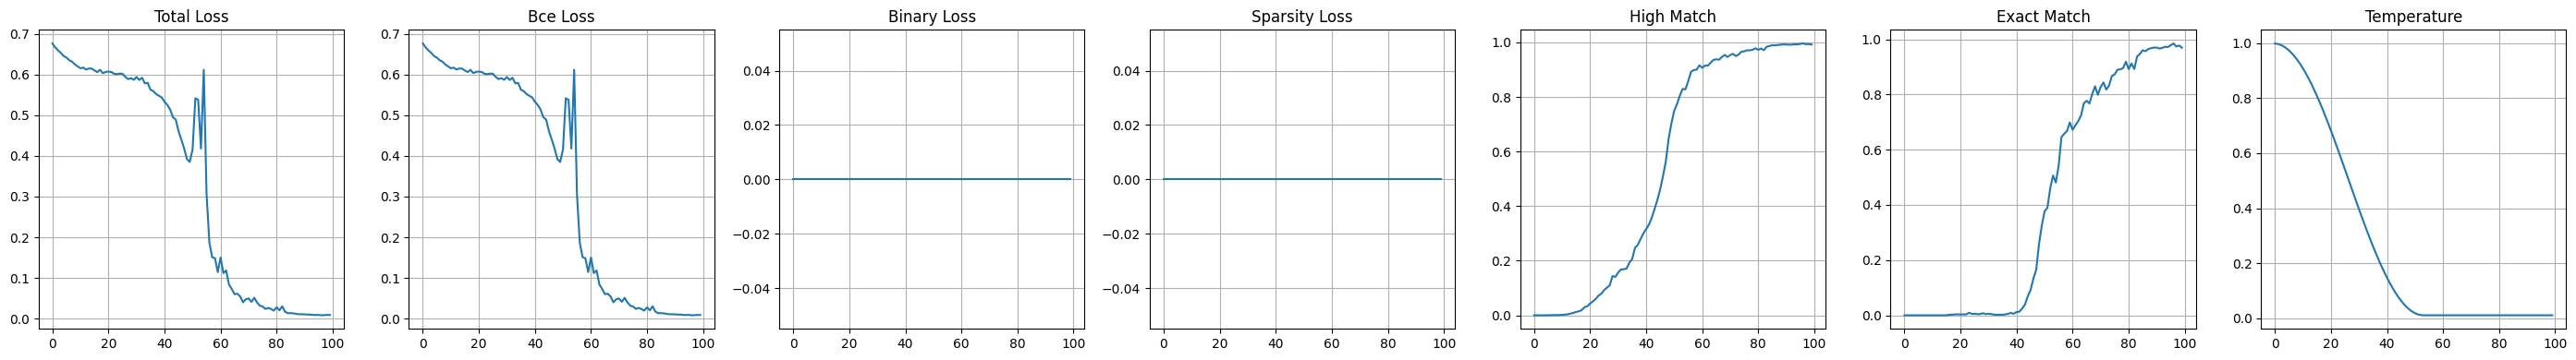

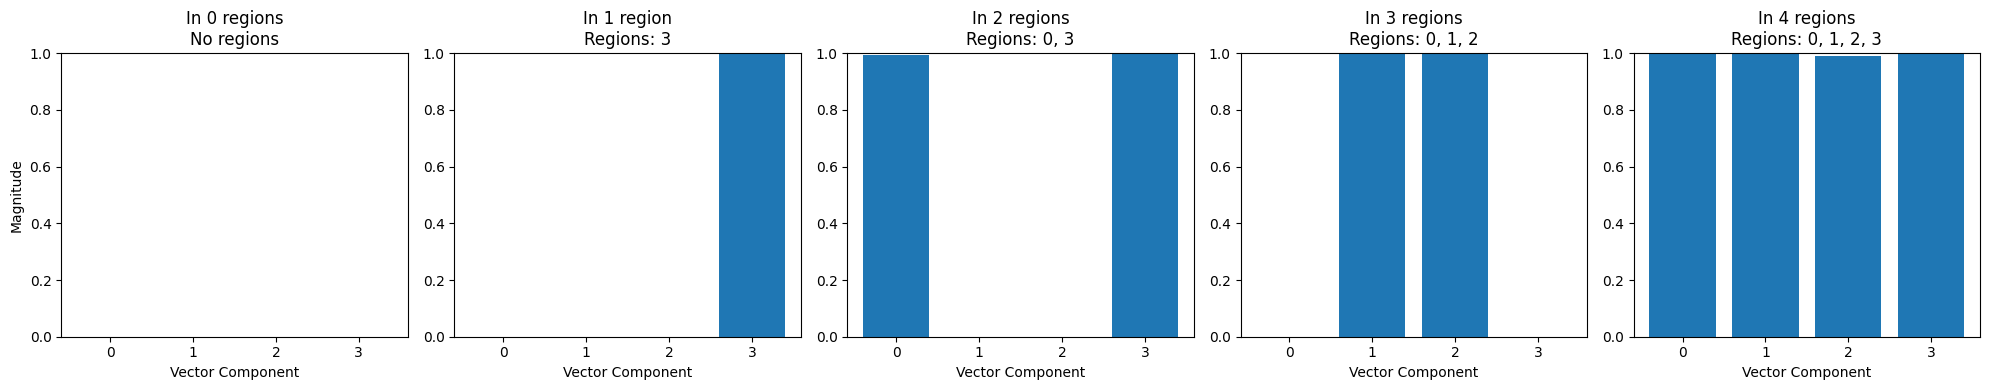

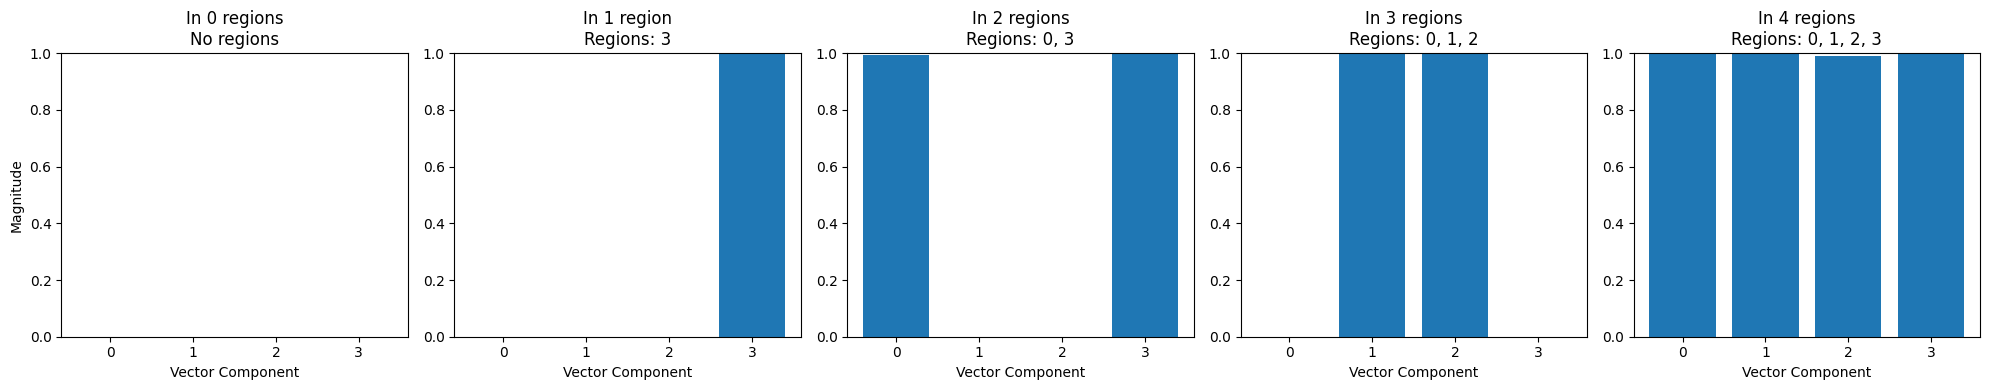

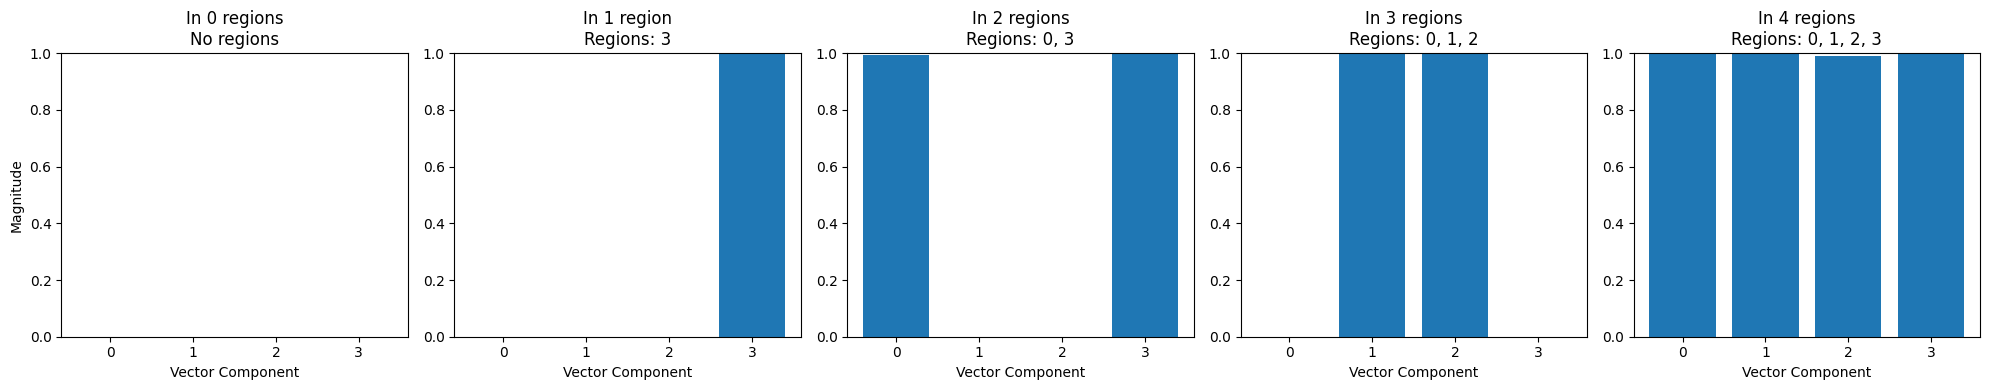

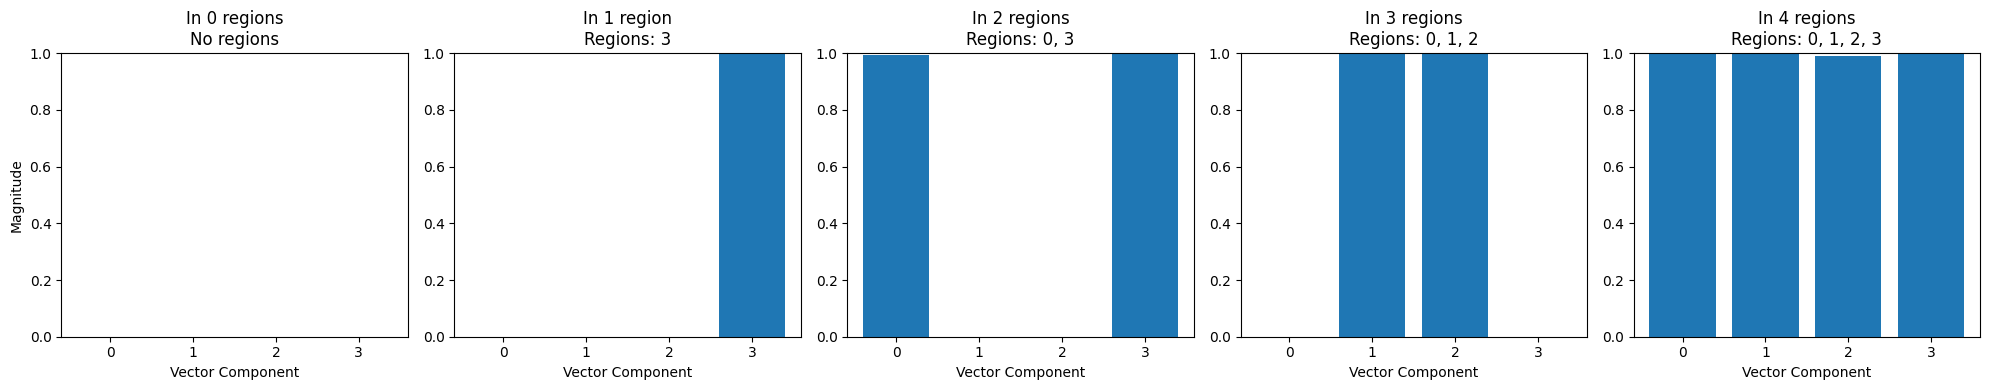

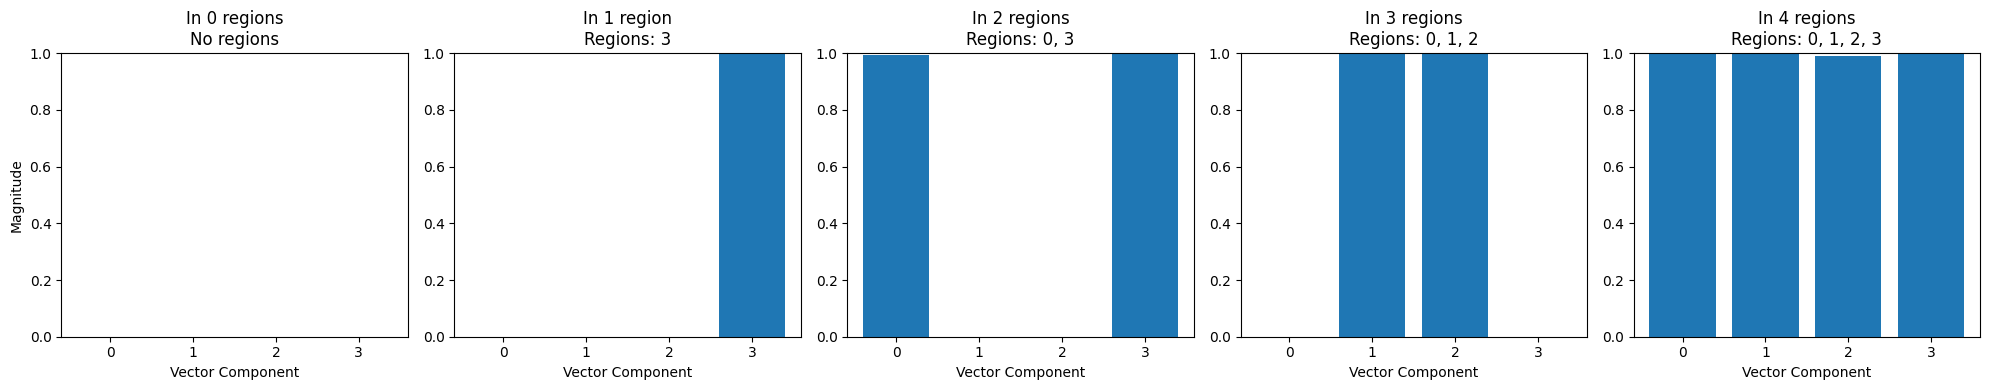

In [8]:
config = TrainingConfig(
    sparsity_coeff=0.,
    binary_coeff=0.,
    epochs=100,
    num_classes=4,
    device="mps",
    learning_rate=1e-2,
    temp_start=1.0,
    temp_end=1e-2
)
trainer = Trainer(config)
model, metrics = trainer.train()

In [53]:
import pyvene as pv
import torch

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig(
    [
        {
            "layer": 8,
            "component": "block_output",
            "intervention_type": pv.VanillaIntervention,
        },
        {
            "component": "wte.output",
            "intervention_type": pv.CollectIntervention,
        },
    ]
)

pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

base, counterfactual = pv_gpt2(
    base=tokenizer("The capital of Spain is", return_tensors="pt"),
    sources=[tokenizer("The capital of Italy is", return_tensors="pt"), None],
    # sources=[tokenizer("The capital of Italy is", return_tensors="pt")],
    unit_locations={"sources->base": 3},
)

/Users/sidbaskaran/miniconda3/envs/interp/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


loaded model


In [50]:
base[1][0].shape

torch.Size([1, 768])